# Table of contents

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-10-15 16:36:32.030281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**cf. tf.keras.utils.pad_sequences와 tensorflow.keras.preprocessing.sequence.pad_sequences**
- `tf.keras.utils.pad_sequences`: `TensorFlow 2.x` 버전에서 제공되며, TensorFlow의 keras 모듈의 일부로 통합되어 있습니다.
- `tensorflow.keras.preprocessing.sequence.pad_sequences`: `TensorFlow 1.x` 및 `2.x`에서 사용할 수 있지만, `TensorFlow 2.x`에서는 권장되는 방식이 아닙니다. 이는 `tf.keras.utils`로 통합된 이후에 일부 기능이 Deprecated(더 이상 사용하지 않도록 권장됨)되었기 때문입니다.

# 0. Introduction

**Dataset**  
- spam(스팸메일) | [Download csv file](https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv) | [Kaggle link](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- Deep learning의 한 분야인 NLP(Natural Language Processing, 자연어 처리)를 통해 처리할 수 있는 대표적인 task인 '스팸 메일 분류'를 진행한다.

**References**  
- [AI-class/SPAM_Mail_Classification.ipynb at main · MyungKyuYi/AI-class](https://github.com/MyungKyuYi/AI-class/blob/main/SPAM_Mail_Classification.ipynb)
- [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)
- [10-02 스팸 메일 분류하기(Spam Detection) - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/22894)

In [2]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv', filename='./datasets/spam.csv')
data = pd.read_csv('spam.csv', encoding='latin1')
print('Number of samples :',len(data))

Number of samples : 5572


In [3]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


```
<columns description>
v1           | 정상메일(ham)/스팸메일(spam) 구분
v2           | 해당 메일의 본문 내용
Unnamed: 2   | 무시
Unnamed: 3   | 무시
Unnamed: 4   | 무시
```

In [4]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
mapping_dict = {'ham': 0, 'spam': 1}
data['v1'] = data['v1'].replace(mapping_dict)
data[:5]

# 다음과 같이 inplace parameter를 사용할 수도 있지만, pandas에서 권장하지 않음.
# data['v1'].replace(mapping_dict, inplace=True) 

/var/folders/m_/5z28qmvj575cs_9xldf0gyd80000gn/T/ipykernel_59476/3427996316.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['v1'] = data['v1'].replace(mapping_dict)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print("missing value 여부 :", data.isnull().values.any())

missing value 여부 : False


In [8]:
print("v2 column의 unique value 수 :", data['v2'].nunique())

# 전체 sample 수는 5572개인데, 그 중 유니크한 값을 가지는 sample은 5169개임.

v2 column의 unique value 수 : 5169


In [9]:
# v2 열의 값이 중복인 샘플이 있다면 중복 제거
data = data.drop_duplicates(subset=['v2'])
print('총 샘플의 수 :',len(data))

# 총 샘플의 수 5572 -> 5169로 중복을 제거

총 샘플의 수 : 5169


In [13]:
class_counts = np.unique(data['v1'], return_counts=True)

np.unique(data['v1'], return_counts=True)

(array([0, 1]), array([4516,  653]))

In [18]:
print(f'정상 메일의 비율 = {np.round(class_counts[1][0] / class_counts[1].sum(), 3)*100}%')
print(f'스팸 메일의 비율 = {np.round(class_counts[1][1] / class_counts[1].sum(), 3)*100}%')

정상 메일의 비율 = 87.4%
스팸 메일의 비율 = 12.6%


In [14]:
class_counts[1].sum()

5169

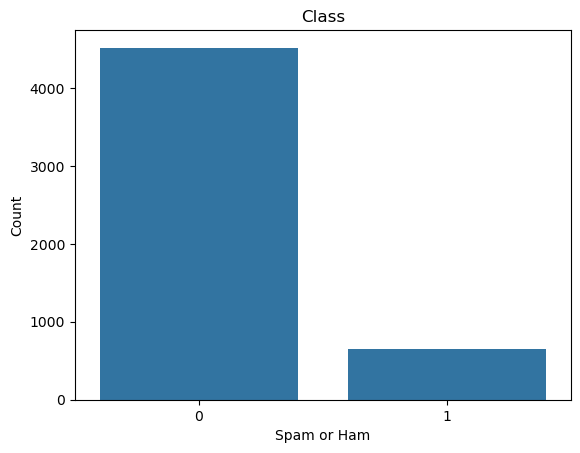

In [11]:
# Check the label count
sns.countplot(data=data, x='v1')
plt.xlabel("Spam or Ham")
plt.ylabel("Count")
plt.title("Class")
plt.show()

In [19]:
X_data = data['v2']
y_data = data['v1']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.2,
                                                    stratify=y_data,
                                                    shuffle=True,
                                                    random_state=42)

print(f"X_train.shape: {X_train.shape}", end=" ")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}", end=" ")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (4135,) y_train.shape: (4135,)
X_test.shape: (1034,) y_test.shape: (1034,)


In [28]:
class_counts_train = np.unique(y_train, return_counts=True)
class_counts_test = np.unique(y_test, return_counts=True)

print('==== train dataset ====')
print(f'정상 메일의 비율 = {np.round(class_counts_train[1][0] / class_counts_train[1].sum(), 3)*100}%')
print(f'스팸 메일의 비율 = {np.round(class_counts_train[1][1] / class_counts_train[1].sum(), 3)*100}%')

print('==== test dataset ====')
print(f'정상 메일의 비율 = {np.round(class_counts_test[1][0] / class_counts_test[1].sum(), 3)*100}%')
print(f'스팸 메일의 비율 = {np.round(class_counts_test[1][1] / class_counts_test[1].sum(), 3)*100}%')

==== train dataset ====
정상 메일의 비율 = 87.4%
스팸 메일의 비율 = 12.6%
==== test dataset ====
정상 메일의 비율 = 87.3%
스팸 메일의 비율 = 12.7%


In [29]:
# keras의 Tokenizer를 사용하여 토큰화와 정수 인코딩 과정을 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[281, 23, 44, 60, 3, 469, 107, 3487, 7, 3488, 180], [556, 23, 218, 752, 316], [12, 854, 583, 61, 24, 397, 2, 16, 1160, 30, 3, 67, 1160, 74, 65], [127, 37, 619, 620, 621, 17, 113, 62, 3489, 12, 142, 925, 4, 3490, 15, 3491, 855, 8, 38, 4, 3492, 201, 60, 1018, 33, 3, 55], [3493, 1335, 22, 2318]]


- [토큰화(Tokenization)](https://wikidocs.net/21698)
- [정수 인코딩(Integer Encoding)](https://wikidocs.net/31766)

In [31]:
# tokenizer는 정수 인코딩 과정에서 매핑한 정수값과 토큰에 대하여
# {토큰: 정수값}의 매핑 정보를 딕셔너리로 유지함
word_to_index = tokenizer.word_index
print(word_to_index)

# 이때 주어진 데이터셋 내에서 빈도수가 높은 토큰 순서대로 1, 2, 3, ...의 정수값에 매핑된다.
# 즉 해당 데이터셋에서는 1에 매핑된 'i'라는 토큰이 가장 빈번하게 등장한다.
# 또한 7815에 매핑된 'cheetos'라는 토큰은 매우 드물게 등장한다.

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'for': 11, 'my': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, '2': 17, 'that': 18, 'call': 19, 'on': 20, 'are': 21, 'now': 22, 'so': 23, 'not': 24, 'but': 25, 'can': 26, "i'm": 27, 'or': 28, 'at': 29, 'do': 30, 'get': 31, 'will': 32, 'if': 33, 'we': 34, 'be': 35, 'just': 36, 'ur': 37, 'with': 38, 'no': 39, 'this': 40, 'up': 41, 'gt': 42, 'lt': 43, 'how': 44, 'when': 45, 'ok': 46, '4': 47, 'from': 48, 'out': 49, 'go': 50, 'what': 51, 'all': 52, 'free': 53, 'know': 54, 'like': 55, 'got': 56, 'then': 57, 'good': 58, 'time': 59, 'come': 60, 'was': 61, 'am': 62, 'he': 63, 'its': 64, 'day': 65, 'there': 66, 'want': 67, 'text': 68, 'only': 69, 'love': 70, 'going': 71, 'send': 72, 'lor': 73, 'one': 74, 'by': 75, 'home': 76, 'as': 77, 'need': 78, 'still': 79, 'txt': 80, 'see': 81, 'about': 82, 'r': 83, 'stop': 84, 'our': 85, 'da': 86, "i'll": 87, 'take': 88, 'reply': 89, 'think': 90, 'sorry': 91, 'bac

In [32]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4329
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.39347408829175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.747930728103128


> 등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않습니다. 만약, 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있습니다. 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있을 겁니다.  
> `tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)`  
> 하지만 이번 실습에서는 별도로 단어 집합의 크기를 제한하진 않겠습니다. 단어 집합의 크기를 vocab_size에 저장하겠습니다. 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장합니다.
> \- [10-02 스팸 메일 분류하기(Spam Detection) - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/22894)

In [34]:
# 단어 집합: train set에 등장하는 token의 수
# 앞서 mapping index가 0 ~ 7815 였으니 총 7816개
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7816


메일의 최대 길이 : 121
메일의 평균 길이 : 15.514631


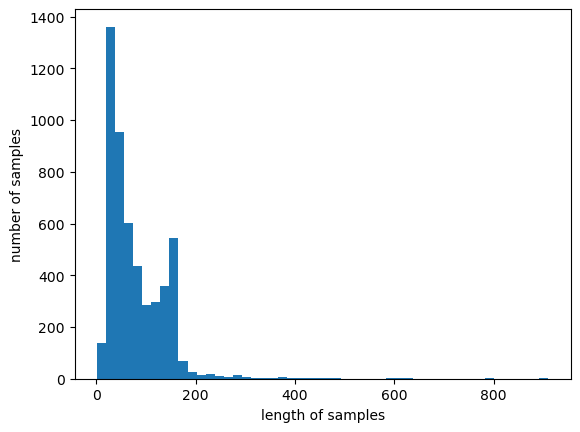

In [35]:
# 전체 샘플(4135개의 메일) 중에서 본문 길이가 가장 긴 메일과 평균을 출력
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
# 위 cell의 '메일의 최대 길이' 출력 값과 동일하게 설정
max_len = 121

# max_len보다 길이가 짧은 샘플들에 대해서 padding을 통해 그 길이를 max_len까지 늘림
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 121)


**cf. [tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)**
```python
pad_sequences(
    sequences,
    maxlen=None,
    dtype='int32',
    padding='pre',    # maxlen보다 짧다면, 앞 뒤 중 어느 부분을 채울지
    truncating='pre', # maxlen보다 길다면, 앞 뒤 중 어느 부분을 자를지
    value=0.0)        # padding할 때 사용되는 value. 부족한 부분을 0.0으로 채움.
```

> 왜 굳이 padding value를 0.0(또는 0)으로 사용해서 채울까?

- 구분 기호: 0은 모델에서 실제 데이터(단어 또는 토큰)와 패딩을 구분하는 역할을 한다. 일반적으로 딥러닝 프레임워크에서는 0은 무시되기 때문에 모델이 시퀀스의 길이를 일정하게 유지하면서도 필요한 부분(0이 아닌 부분)만 학습할 수 있도록 한다.
- 효율성: 0은 연산에서 추가적인 비용이 들지 않기 때문에, 패딩을 위해 선택되는 값으로 일반적으로 사용됩니다. 또한, 많은 딥러닝 프레임워크에서 0은 기본적으로 무시되거나 특별한 처리를 받지 않기 때문에, 계산 효율성을 높이는 데 유리합니다.

> RNN은 이론적으로 length가 가변적이어도 상관없는데, 왜 `pad.sequences`를 사용해서 모든 샘플의 시퀀스 길이를 통일할까?

RNN (Recurrent Neural Network)은 이론적으로 가변적인 길이의 시퀀스를 처리할 수 있지만, 실전에서 대부분의 RNN 모델은 고정된 길이의 입력 시퀀스를 처리할 수 있도록 설계되는 경우가 많다. `pad_sequences`를 사용하여 모든 시퀀스를 동일한 길이(maxlen)로 맞추는 이유는 다음과 같다:

1. 병렬 처리의 효율성
딥러닝 모델은 보통 GPU에서 병렬 처리를 통해 빠르게 학습합니다. 하지만 시퀀스 길이가 가변적이면 병렬 처리가 어려워집니다. 같은 크기의 배치를 만들기 위해 시퀀스 길이를 고정시키면, 모든 데이터가 동일한 크기이므로 병렬 처리가 가능해집니다. 이로 인해 학습 속도가 크게 향상됩니다.
2. 일괄 처리 (Batch Processing)
RNN을 학습할 때는 일반적으로 여러 샘플을 하나의 배치로 묶어서 학습합니다. 이때 배치 내 모든 시퀀스가 동일한 길이를 가져야 모델이 입력을 처리할 수 있습니다. 시퀀스 길이가 다르면 배치를 구성하기 어렵고, 효율적인 학습이 불가능해집니다.
3. 모델 구현의 간단화
모델 코드와 구현이 단순해집니다. 시퀀스 길이가 고정되어 있으면, 모델을 구현할 때 길이 변화를 따로 처리할 필요가 없으므로 모델 구조를 간단하게 만들 수 있습니다. 특히 CNN과 함께 사용하는 경우, 고정된 입력 길이가 필수적입니다.
4. 메모리 사용 효율성
시퀀스 길이가 다양한 데이터를 개별적으로 처리하면 메모리 사용이 비효율적일 수 있습니다. 패딩을 통해 길이를 맞추면 메모리 사용을 예측할 수 있고, 모델이 더 안정적으로 동작합니다.
5. 동일한 학습 패턴
RNN은 시퀀스의 시간적 의존성을 학습합니다. 시퀀스 길이가 동일하면 학습이 더 균일해지고, 모델이 더 안정적으로 수렴할 수 있습니다. 가변 길이 시퀀스를 사용하면 모델이 시퀀스의 다양한 길이에서 발생하는 불균형한 학습 패턴을 학습해야 하므로 학습이 어려워질 수 있습니다.

**요약**  
RNN은 가변 길이의 입력을 처리할 수 있지만, 학습 속도, 병렬 처리 효율성, 일괄 처리의 용이성 등을 고려하여 시퀀스 길이를 고정하는 것이 일반적입니다. 이는 특히 대규모 데이터셋에서 학습할 때 중요한 요소입니다. pad_sequences를 사용하여 시퀀스를 동일한 길이로 맞추면, 모델이 더 효율적이고 안정적으로 학습할 수 있습니다.


In [38]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

2024-10-15 17:13:57.683120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/4
52/52 [==============================] - 2s 24ms/step - loss: 0.4260 - acc: 0.8189 - val_loss: 0.2846 - val_acc: 0.9722
Epoch 2/4
52/52 [==============================] - 1s 21ms/step - loss: 0.1514 - acc: 0.9649 - val_loss: 0.0826 - val_acc: 0.9758
Epoch 3/4
52/52 [==============================] - 1s 20ms/step - loss: 0.0675 - acc: 0.9816 - val_loss: 0.0526 - val_acc: 0.9843
Epoch 4/4
52/52 [==============================] - 1s 21ms/step - loss: 0.0349 - acc: 0.9912 - val_loss: 0.0412 - val_acc: 0.9879


In [39]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 4ms/step - loss: 0.0767 - acc: 0.9807

 테스트 정확도: 0.9807


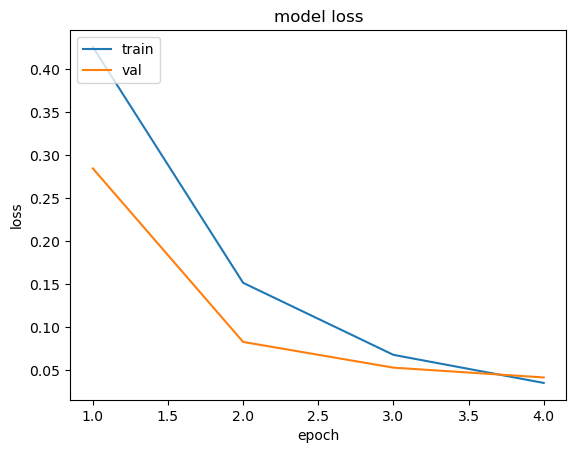

In [40]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()